In [1]:
#!pip install --user imblearn
#!pip install optuna

In [2]:
def agrupar_categorias(df, columnas, umbral):
    for col in columnas:
        conteo_categorias = df[col].value_counts()
        categorias_a_agrupar = conteo_categorias[conteo_categorias < umbral].index.tolist()
        df.loc[:,col] = df[col].apply(lambda x: 'otro_' + col if x in categorias_a_agrupar else x)
    return df

In [3]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
import sys
sys.path.append("../../")

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import chi2
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from xgboost.sklearn import XGBClassifier
from scipy.stats import chi2_contingency
import optuna

import warnings
warnings.filterwarnings("ignore")

In [4]:
df_train = pd.read_csv("../data/raw/training.csv")

In [5]:
df_numeric = df_train.select_dtypes(include=["number"]).drop(columns=["Target"])
df_categorical = df_train.select_dtypes(include=["object"])
y = df_train["Target"]

In [6]:
constants_drop_columns = list(df_numeric.columns[df_numeric.nunique()==1])
df_train_procesing_1 = df_numeric.drop(columns=constants_drop_columns)
df_train_procesing_1 = df_train_procesing_1.fillna(df_train_procesing_1.mean())

In [7]:
# Calculate the correlation matrix
correlation_matrix = df_train_procesing_1.corr()

# Identify features with high correlation
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

# Select features with correlation below the threshold
correlation_drop_columns = high_corr_features
df_train_procesing_2 = df_train_procesing_1.drop(columns=correlation_drop_columns)

(0.0, 40.0)

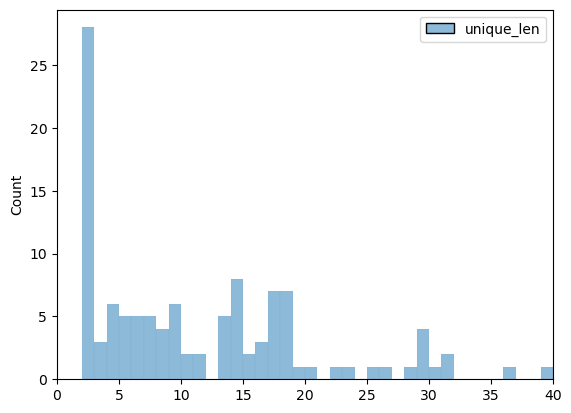

In [8]:
numeric_columns_unique_len = []
for column in df_train_procesing_2.columns:
    numeric_columns_unique_len.append(len(df_train_procesing_2[column].unique()))
numeric_columns_unique_len_df = pd.DataFrame({
    'feature':df_train_procesing_2.columns,
    'unique_len': numeric_columns_unique_len
})
sns.histplot(numeric_columns_unique_len_df.sort_values('unique_len'), binwidth= 1)
plt.xlim(0,40)

<AxesSubplot:>

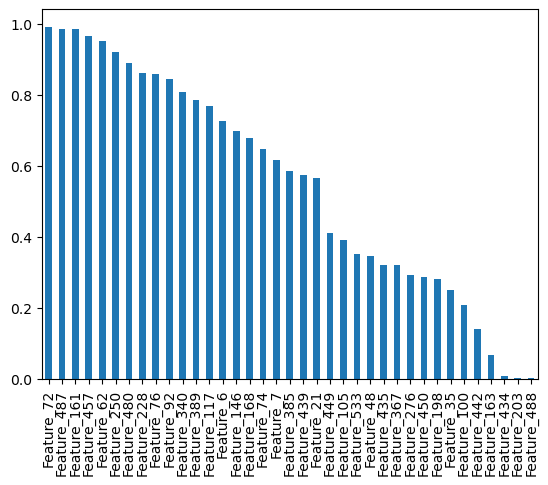

In [9]:
X = df_train_procesing_2[list(numeric_columns_unique_len_df[numeric_columns_unique_len_df.unique_len<5].feature.values)]
X = X.select_dtypes(include=["number"])
X = X.fillna(X.mean())
chi_scores = chi2(X,y)
chi_scores
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()


In [10]:
categoricas_select_columns = p_values.keys()[p_values>0.25]

In [11]:
chi_drop_columns = set(numeric_columns_unique_len_df[numeric_columns_unique_len_df.unique_len<5].feature.values)-set(categoricas_select_columns+["Target"])-set(["Target"])

In [12]:
df_train_procesing_3 = df_train_procesing_2.drop(columns=chi_drop_columns)
df_train_procesing_3.head(1)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_14,...,Feature_529,Feature_530,Feature_532,Feature_534,Feature_535,Feature_537,Feature_540,Feature_541,Feature_542,Feature_545
0,0.144231,0.105263,0.9,0.66665,0.018114,0.07386,0.5625,0.166667,0.038552,0.0,...,0.25,0.210526,0.292566,0.2768,0.0,0.0,0.216696,0.0,0.0,0.0


In [13]:
X_cate = df_train.select_dtypes("object")
X_cate = X_cate.fillna(X_cate.mode())

In [14]:
p_value = []
for i in X_cate.columns:
    print(i)
    crosstab = pd.crosstab(X_cate[i], y)
    print(chi2_contingency(crosstab))
    p_value.append(chi2_contingency(crosstab)[1])

Feature_82
(11.35299205546586, 0.9693417777592401, 22, array([[8.91533359e-01, 1.08466641e-01],
       [8.91533359e-01, 1.08466641e-01],
       [2.67460008e+00, 3.25399922e-01],
       [8.91533359e-01, 1.08466641e-01],
       [6.86480687e+01, 8.35193133e+00],
       [8.91533359e-01, 1.08466641e-01],
       [2.67460008e+00, 3.25399922e-01],
       [8.91533359e-01, 1.08466641e-01],
       [8.91533359e-01, 1.08466641e-01],
       [8.91533359e-01, 1.08466641e-01],
       [8.91533359e-01, 1.08466641e-01],
       [8.91533359e-01, 1.08466641e-01],
       [8.91533359e-01, 1.08466641e-01],
       [8.91533359e-01, 1.08466641e-01],
       [1.78306672e+00, 2.16933281e-01],
       [8.91533359e-01, 1.08466641e-01],
       [8.91533359e-01, 1.08466641e-01],
       [8.91533359e-01, 1.08466641e-01],
       [1.78306672e+00, 2.16933281e-01],
       [2.94206009e+01, 3.57939914e+00],
       [5.32245416e+02, 6.47545845e+01],
       [1.60565158e+03, 1.95348420e+02],
       [2.76375341e+01, 3.36246586e+00]]))


In [15]:
chiqcategorical_drop_columns = X_cate.columns[np.array(p_value)>0.25]
categorical_select_columns = X_cate.columns[np.array(p_value)<0.25]

In [16]:
X_new = X_cate[categorical_select_columns]
X_new = agrupar_categorias(X_new, categorical_select_columns, 31)

In [17]:
le = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
le.fit(X_new)
X_new_value = le.transform(X_new)

In [18]:
X_new_value.shape

(2563, 29)

In [19]:
df_train_procesing_3.dtypes.value_counts()

float64    268
dtype: int64

In [20]:
n_components = 60
# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_train_procesing_3)

# Apply PCA
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with principal components
pc_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
pc_df = pd.DataFrame(data=principal_components, columns=pc_columns)

# Print explained variance
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio.sum())

Explained Variance Ratio:
0.6144966872452551


In [21]:
X_train = np.concatenate((np.array(pc_df), X_new_value), axis=1)
y_train = y

In [113]:
# Muestreo

oversample = SMOTE(sampling_strategy=0.4)
#X_train_pre, y_train_pre = oversample.fit_resample(X_train, y_train)
X_train_pre, y_train_pre = X_train.copy(), y_train.copy()

In [114]:
from imblearn.pipeline import Pipeline


In [120]:
# Define la función objetivo para la optimización de hiperparámetros
def objective(trial):
    # Define los hiperparámetros que se optimizarán
    param = {
        "multi_class": 'ovr',
        "verbose": 0,
        "penalty": trial.suggest_categorical("penalty", ['l1', 'l2']),
        "C": trial.suggest_float("C", 1e-8, 1.0, log=True),
        "solver": trial.suggest_categorical("solver", ['lbfgs', 'liblinear', 'saga']),
        "max_iter": trial.suggest_categorical("max_iter", [100, 1000, 2500, 5000])
    }
    
    # Crea un modelo de regresión logística con los hiperparámetros definidos
    lr_model = LogisticRegression(**param)
    steps = [('over', SMOTE(sampling_strategy=0.3)), ('model', lr_model)]
    pipeline = Pipeline(steps=steps)
    # Realiza validación cruzada para evaluar el modelo
    score = cross_val_score(
    pipeline,
    X_train_pre,
    y_train_pre,
    scoring=make_scorer(brier_score_loss, needs_proba=True),
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    )
    
    return np.mean(score)



In [121]:
# Crea un objeto de estudio de Optuna para la optimización
study = optuna.create_study(direction="minimize")

# Realiza la optimización de hiperparámetros con un número limitado de iteraciones y tiempo máximo
study.optimize(objective, n_trials=30,
    timeout=600,
    show_progress_bar=True)

# Imprime información sobre los resultados de la optimización
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-16 14:54:21,953] A new study created in memory with name: no-name-ce234526-26dc-4577-a0b9-b228b3367f0d


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-12-16 14:54:21,998] Trial 0 finished with value: 0.25 and parameters: {'penalty': 'l1', 'C': 9.144624547987398e-05, 'solver': 'liblinear', 'max_iter': 2500}. Best is trial 0 with value: 0.25.
[I 2023-12-16 14:54:24,575] Trial 1 finished with value: 0.1138988091703819 and parameters: {'penalty': 'l1', 'C': 0.09184197328356127, 'solver': 'saga', 'max_iter': 5000}. Best is trial 1 with value: 0.1138988091703819.
[I 2023-12-16 14:54:24,602] Trial 2 finished with value: 0.18029402677455542 and parameters: {'penalty': 'l1', 'C': 3.003655654912915e-05, 'solver': 'saga', 'max_iter': 1000}. Best is trial 1 with value: 0.1138988091703819.
[I 2023-12-16 14:54:24,974] Trial 3 finished with value: 0.11147226504669895 and parameters: {'penalty': 'l2', 'C': 6.1452051691792166e-06, 'solver': 'saga', 'max_iter': 2500}. Best is trial 3 with value: 0.11147226504669895.
[I 2023-12-16 14:54:25,008] Trial 4 finished with value: 0.2282765105219721 and parameters: {'penalty': 'l2', 'C': 8.585699389999

In [122]:
trial.params

{'penalty': 'l2',
 'C': 0.0007441952674016755,
 'solver': 'lbfgs',
 'max_iter': 2500}

In [118]:
# Crea un modelo de regresión logística con los hiperparámetros definidos
trial.params["multi_class"] = 'ovr'
trial.params["verbose"] = 0
lr_model = LogisticRegression(**trial.params)
# Realiza validación cruzada para evaluar el modelo
score = cross_val_score(
    lr_model,
    X_train,
    y_train,
    scoring=make_scorer(brier_score_loss, needs_proba=True),
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    )

In [119]:
np.mean(score)

0.09531978063713697

### Xgboost

In [77]:
# Define la función objetivo para la optimización de hiperparámetros
def objective(trial):
    # Define los hiperparámetros que se optimizarán
    param = {
        "verbose": 1,
        "seed":19970808,
        "objective":"binary:logistic",
        "learning_rate":0.1,
        "n_estimators": trial.suggest_categorical("n_estimators", [5,20,50,100]),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0)
    }
    
    # Crea un modelo de regresión logística con los hiperparámetros definidos
    xgb_model = XGBClassifier(**param)
    
    # Realiza validación cruzada para evaluar el modelo
    score = cross_val_score(
    xgb_model,
    X_train_pre,
    y_train_pre,
    scoring=make_scorer(brier_score_loss, needs_proba=True),
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    )
    
    return np.mean(score)



In [78]:
# Crea un objeto de estudio de Optuna para la optimización
study = optuna.create_study(direction="minimize")

# Realiza la optimización de hiperparámetros con un número limitado de iteraciones y tiempo máximo
study.optimize(objective, n_trials=30,
    timeout=600,
    show_progress_bar=True)

# Imprime información sobre los resultados de la optimización
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-16 14:40:11,165] A new study created in memory with name: no-name-b5fe446b-a597-4b35-aa37-c8d26b5e6121


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-12-16 14:40:12,406] Trial 0 finished with value: 0.06749010306533769 and parameters: {'n_estimators': 100, 'max_depth': 10, 'lambda': 0.0012375124301367598, 'alpha': 0.057615133965669536, 'subsample': 0.9403711991133692, 'colsample_bytree': 0.8394544134382638}. Best is trial 0 with value: 0.06749010306533769.
[I 2023-12-16 14:40:12,710] Trial 1 finished with value: 0.10366083029614682 and parameters: {'n_estimators': 20, 'max_depth': 8, 'lambda': 0.030896590004747412, 'alpha': 0.4260662168797139, 'subsample': 0.36338451391443044, 'colsample_bytree': 0.68469166703951}. Best is trial 0 with value: 0.06749010306533769.
[I 2023-12-16 14:40:12,838] Trial 2 finished with value: 0.15772291313710668 and parameters: {'n_estimators': 5, 'max_depth': 6, 'lambda': 9.83566226300825e-07, 'alpha': 3.766060629197138e-05, 'subsample': 0.8318957217176126, 'colsample_bytree': 0.295805160005372}. Best is trial 0 with value: 0.06749010306533769.
[I 2023-12-16 14:40:13,524] Trial 3 finished with val

[I 2023-12-16 14:40:32,342] Trial 26 finished with value: 0.06761459915774139 and parameters: {'n_estimators': 100, 'max_depth': 9, 'lambda': 0.005758202349759376, 'alpha': 0.14876610100701287, 'subsample': 0.7494748621996585, 'colsample_bytree': 0.7048970071284149}. Best is trial 21 with value: 0.06742469301875137.
[I 2023-12-16 14:40:32,603] Trial 27 finished with value: 0.08875565515002039 and parameters: {'n_estimators': 50, 'max_depth': 4, 'lambda': 3.2977077094276045e-05, 'alpha': 0.03975270887883367, 'subsample': 0.6166437860668514, 'colsample_bytree': 0.6160012908849561}. Best is trial 21 with value: 0.06742469301875137.
[I 2023-12-16 14:40:33,193] Trial 28 finished with value: 0.08633790444030709 and parameters: {'n_estimators': 20, 'max_depth': 10, 'lambda': 0.36103897485607234, 'alpha': 0.20098134007827492, 'subsample': 0.9292658129815144, 'colsample_bytree': 0.5041579620225347}. Best is trial 21 with value: 0.06742469301875137.
[I 2023-12-16 14:40:33,669] Trial 29 finished 

In [79]:
trial.params

{'n_estimators': 100,
 'max_depth': 10,
 'lambda': 1.4856816506419549e-05,
 'alpha': 0.9643517221799367,
 'subsample': 0.8761067893449433,
 'colsample_bytree': 0.7275936303729902}

In [80]:
trial.params["seed"] = 199970808
estimator = XGBClassifier(**trial.params)
score = cross_val_score(
        estimator,
        X_train,
        y_train,
        scoring=make_scorer(brier_score_loss, needs_proba=True),
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
)

In [81]:
np.mean(score)

0.10505981548589971

### XGBOOST

In [82]:
df_sebas = pd.read_csv("../data/processed/categorized_data.csv")
X_sebas = df_sebas.drop('Target', axis=1)
y_sebas = df_sebas['Target']

In [91]:
X_sebas = X_sebas.fillna(X_sebas.mean())

In [92]:
# # Muestreo

oversample = SMOTE(sampling_strategy=0.4)
X_sebas_pre, y_sebas_pre = oversample.fit_resample(X_sebas, y_sebas)
#X_sebas_pre, y_sebas_pre = X_sebas.copy(), y_sebas.copy()

In [93]:
# Define la función objetivo para la optimización de hiperparámetros
def objective(trial):
    # Define los hiperparámetros que se optimizarán
    param = {
        "verbose": 1,
        "seed":19970808,
        "objective":"binary:logistic",
        "learning_rate":0.1,
        "n_estimators": trial.suggest_categorical("n_estimators", [5,20,50,100]),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0)
    }
    
    # Crea un modelo de regresión logística con los hiperparámetros definidos
    xgb_model = XGBClassifier(**param)
    
    # Realiza validación cruzada para evaluar el modelo
    score = cross_val_score(
    xgb_model,
    X_sebas_pre,
    y_sebas_pre,
    scoring=make_scorer(brier_score_loss, needs_proba=True),
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    )
    
    return np.mean(score)



In [94]:
# Crea un objeto de estudio de Optuna para la optimización
study = optuna.create_study(direction="minimize")

# Realiza la optimización de hiperparámetros con un número limitado de iteraciones y tiempo máximo
study.optimize(objective, n_trials=30,
    timeout=600,
    show_progress_bar=True)

# Imprime información sobre los resultados de la optimización
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-16 14:44:02,412] A new study created in memory with name: no-name-c20f3d79-7e6a-4fb1-9762-41bb5120a12a


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-12-16 14:44:02,761] Trial 0 finished with value: 0.17550389622724602 and parameters: {'n_estimators': 20, 'max_depth': 1, 'lambda': 8.577518938908117e-05, 'alpha': 1.757134468610331e-05, 'subsample': 0.3243397383489508, 'colsample_bytree': 0.8900496962058577}. Best is trial 0 with value: 0.17550389622724602.
[I 2023-12-16 14:44:05,574] Trial 1 finished with value: 0.07318053706650714 and parameters: {'n_estimators': 100, 'max_depth': 9, 'lambda': 0.031248593400310953, 'alpha': 0.028493401296833528, 'subsample': 0.2900945484074476, 'colsample_bytree': 0.29166932570056786}. Best is trial 1 with value: 0.07318053706650714.
[I 2023-12-16 14:44:06,319] Trial 2 finished with value: 0.09437369254007129 and parameters: {'n_estimators': 50, 'max_depth': 3, 'lambda': 0.017573220514581676, 'alpha': 0.0016730298637822375, 'subsample': 0.2812029192411492, 'colsample_bytree': 0.7553981759282007}. Best is trial 1 with value: 0.07318053706650714.
[I 2023-12-16 14:44:08,945] Trial 3 finished wi

[I 2023-12-16 14:45:08,284] Trial 26 finished with value: 0.06733317205903461 and parameters: {'n_estimators': 100, 'max_depth': 8, 'lambda': 6.935813980737977e-07, 'alpha': 0.021982248091553327, 'subsample': 0.6171268723599669, 'colsample_bytree': 0.8975428057551079}. Best is trial 18 with value: 0.06708111619924127.
[I 2023-12-16 14:45:11,815] Trial 27 finished with value: 0.0691673802045956 and parameters: {'n_estimators': 100, 'max_depth': 8, 'lambda': 4.483515782058898e-08, 'alpha': 0.015542268763680471, 'subsample': 0.4224008697047501, 'colsample_bytree': 0.8646904719814591}. Best is trial 18 with value: 0.06708111619924127.
[I 2023-12-16 14:45:15,844] Trial 28 finished with value: 0.06694840436689582 and parameters: {'n_estimators': 100, 'max_depth': 9, 'lambda': 1.4417408433067398e-06, 'alpha': 0.0678776475662691, 'subsample': 0.5641560242473829, 'colsample_bytree': 0.9517611810688649}. Best is trial 28 with value: 0.06694840436689582.
[I 2023-12-16 14:45:16,275] Trial 29 finis

In [95]:
trial.params["seed"] = 199970808

In [96]:
estimator = XGBClassifier(**trial.params)
score = cross_val_score(
        estimator,
        X_sebas,
        y_sebas,
        scoring=make_scorer(brier_score_loss, needs_proba=True),
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
)

In [97]:
np.mean(score)

0.10635655064998735